In [1]:
install.packages("GGally")
library(GGally)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
if (!require(car)) install.packages("car")
library(car)

Loading required package: car

Loading required package: carData



In [3]:
library(gvlma)

In [4]:
library(mgcv)


Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.



In [5]:
data <- read.csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

In [12]:
head(data)


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


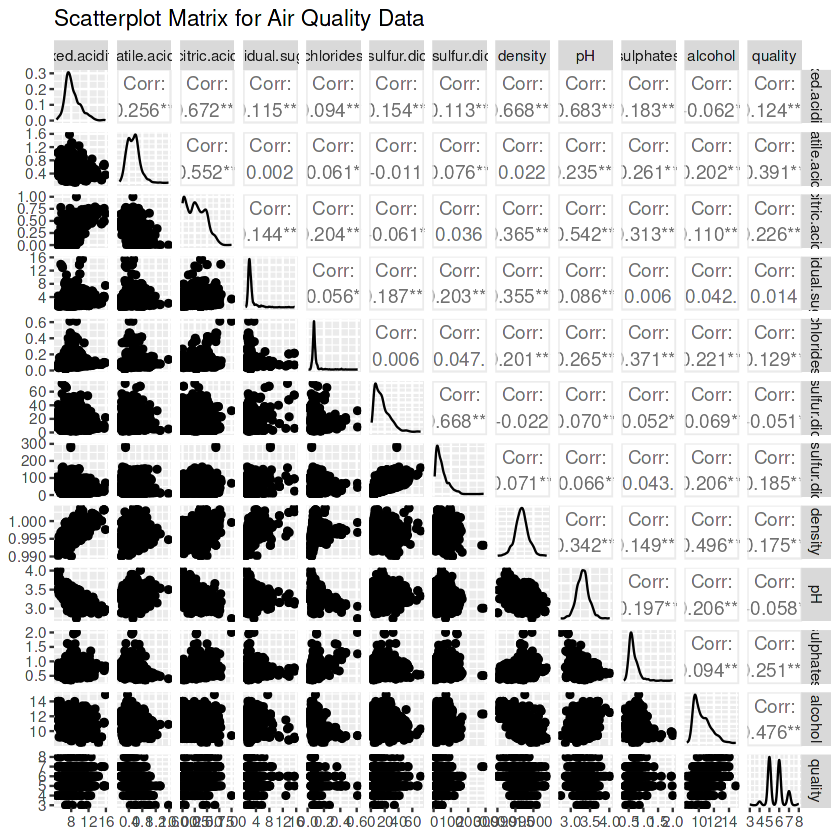

In [6]:
ggpairs(data, title = "Scatterplot Matrix for Air Quality Data")


In [6]:
fit <- lm(formula = quality ~ alcohol + volatile.acidity + sulphates + 
    fixed.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + residual.sugar, data = data)

In [7]:
summary(fit)


Call:
lm(formula = quality ~ alcohol + volatile.acidity + sulphates + 
    fixed.acidity + citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide + density + pH + residual.sugar, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.68911 -0.36652 -0.04699  0.45202  2.02498 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.197e+01  2.119e+01   1.036   0.3002    
alcohol               2.762e-01  2.648e-02  10.429  < 2e-16 ***
volatile.acidity     -1.084e+00  1.211e-01  -8.948  < 2e-16 ***
sulphates             9.163e-01  1.143e-01   8.014 2.13e-15 ***
fixed.acidity         2.499e-02  2.595e-02   0.963   0.3357    
citric.acid          -1.826e-01  1.472e-01  -1.240   0.2150    
chlorides            -1.874e+00  4.193e-01  -4.470 8.37e-06 ***
free.sulfur.dioxide   4.361e-03  2.171e-03   2.009   0.0447 *  
total.sulfur.dioxide -3.265e-03  7.287e-04  -4.480 8.00e-06 ***
density              -1.788e+

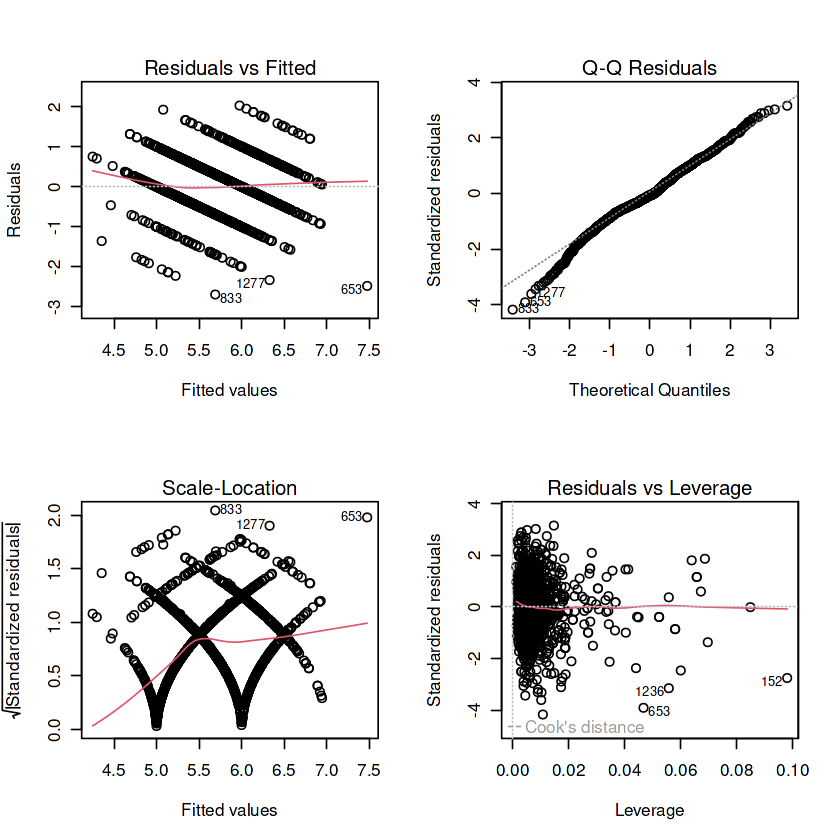

In [8]:
par(mfrow=c(2,2))
plot(fit)

## As we can see from the QQ-PLOT that our model has outliers so we need to remove them

[1] 653 833

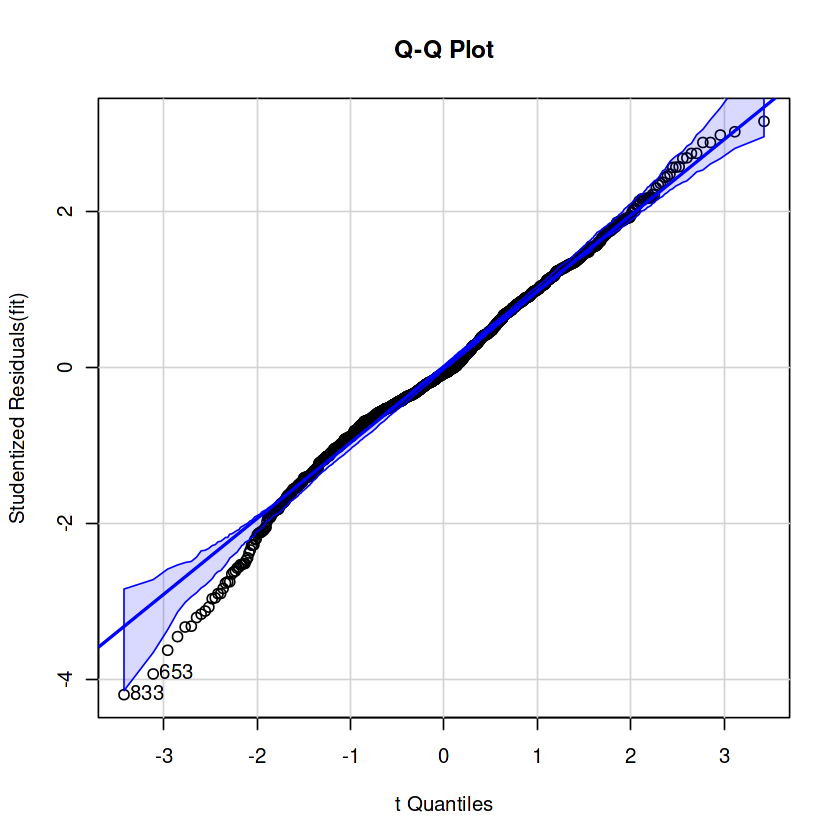

In [10]:
qqPlot(fit, labels=row.names(data$quality), id.method="identify",
 simulate=TRUE, main="Q-Q Plot")

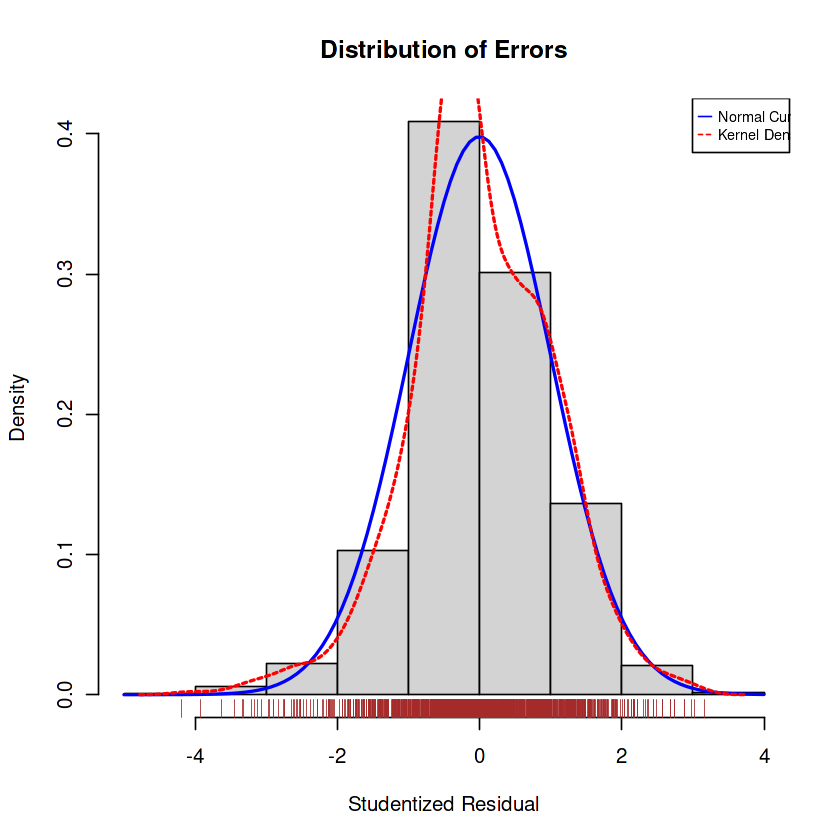

In [11]:
residplot <- function(fit, nbreaks=10) {
 z <- rstudent(fit)
 hist(z, breaks=nbreaks, freq=FALSE, 
 xlab="Studentized Residual", 
 main="Distribution of Errors")
 rug(jitter(z), col="brown")
 curve(dnorm(x, mean=mean(z), sd=sd(z)), 
 add=TRUE, col="blue", lwd=2)
 lines(density(z)$x, density(z)$y, 
 col="red", lwd=2, lty=2)
 legend("topright", 
 legend = c( "Normal Curve", "Kernel Density Curve"), 
 lty=1:2, col=c("blue","red"), cex=.7)
 } 

residplot(fit)

## Removing the outliers using the IQR method

In [9]:
# create detect outlier function
detect_outlier <- function(x) {
   
  # calculate first quantile
  Quantile1 <- quantile(x, probs=.25)
   
  # calculate third quantile
  Quantile3 <- quantile(x, probs=.75)
   
  # calculate interquartile range
  IQR = Quantile3 - Quantile1
   
  # return true or false
  x > Quantile3 + (IQR * 1.5) | x < Quantile1 - (IQR * 1.5)
}
 
# create remove outlier function
remove_outlier <- function(dataframe, columns = names(dataframe)) {
   
  # for loop to traverse in columns vector
  for (col in columns) {
     
    # remove observation if it satisfies outlier function
    dataframe <- dataframe[!detect_outlier(dataframe[[col]]), ]
  }
    return(dataframe)
   
}

In [10]:
no_outlier_data <-  remove_outlier(data)
nrow(no_outlier_data)

[1] 1124

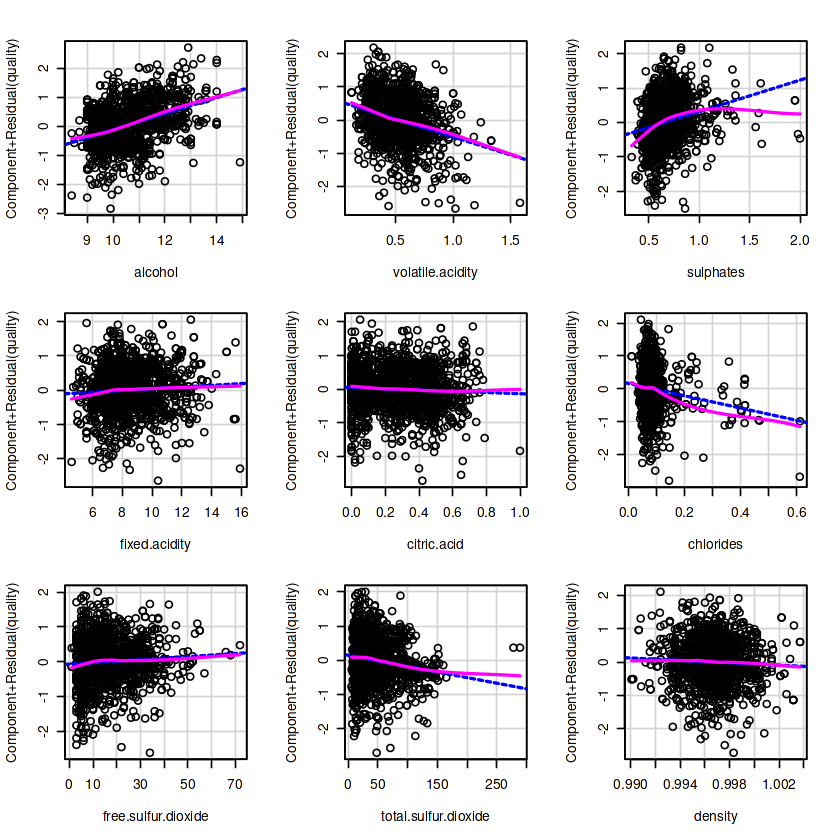

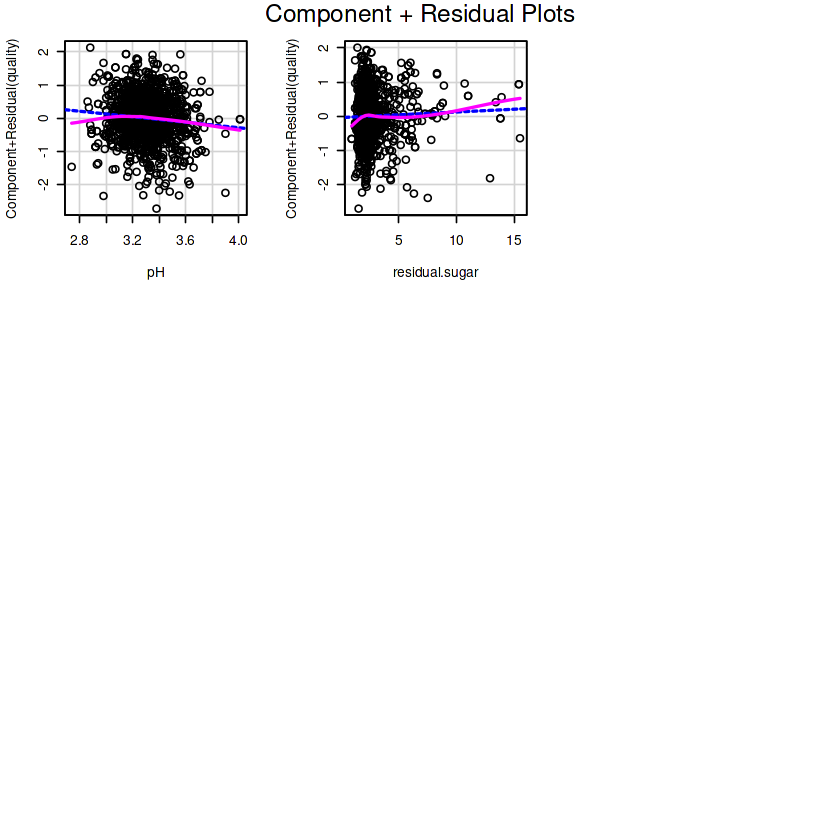

In [40]:
crPlots(fit)


## After removing the outliers we need to normalize the data with the min-max method

In [13]:
library(caret)


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




In [14]:
process <- preProcess(as.data.frame(no_outlier_data), method=c("range"))

norm_scale <- predict(process, as.data.frame(no_outlier_data))


In [15]:
no_outlier_data <- na.omit(norm_scale)


In [16]:
summary(no_outlier_data)

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.2778   1st Qu.:0.3051   1st Qu.:0.1096   1st Qu.:0.2917  
 Median :0.3750   Median :0.4520   Median :0.3288   Median :0.3750  
 Mean   :0.4228   Mean   :0.4550   Mean   :0.3357   Mean   :0.4081  
 3rd Qu.:0.5417   3rd Qu.:0.5763   3rd Qu.:0.5342   3rd Qu.:0.5000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   chlorides      free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.0000   Min.   :0.0000      Min.   :0.0000       Min.   :0.0000  
 1st Qu.:0.3750   1st Qu.:0.1795      1st Qu.:0.1495       1st Qu.:0.3776  
 Median :0.4865   Median :0.3077      Median :0.2710       Median :0.5153  
 Mean   :0.4916   Mean   :0.3542      Mean   :0.3281       Mean   :0.5123  
 3rd Qu.:0.6081   3rd Qu.:0.4872      3rd Qu.:0.4486       3rd Qu.:0.6301  
 Max.   :1.0000   Max.   :1.0000      Max.   :1.0000       Ma

# Autocorrelation test 
## as we see we need to drop fixed.acidity and density 

In [39]:
 sqrt(vif(fit)) > 2

alcohol     volatile.acidity            sulphates 
               FALSE                FALSE                FALSE 
       fixed.acidity          citric.acid            chlorides 
                TRUE                FALSE                FALSE 
 free.sulfur.dioxide total.sulfur.dioxide              density 
               FALSE                FALSE                 TRUE 
                  pH       residual.sugar 
               FALSE                FALSE

In [48]:
fit1 <-lm(formula = quality ~ alcohol + volatile.acidity + exp(sulphates) + 
    citric.acid + chlorides + free.sulfur.dioxide + 
    total.sulfur.dioxide +  pH , data = no_outlier_data)

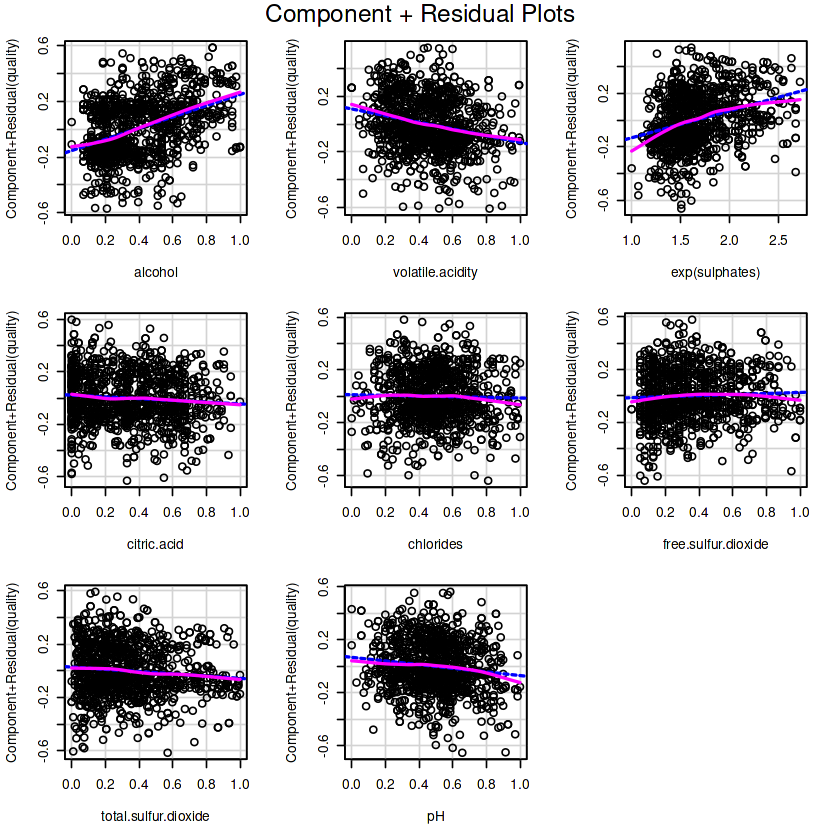

In [51]:
crPlots(fit1)


In [49]:
summary(fit1)


Call:
lm(formula = quality ~ alcohol + volatile.acidity + exp(sulphates) + 
    citric.acid + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    pH, data = no_outlier_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63119 -0.12035 -0.02452  0.14739  0.57618 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.27822    0.05156   5.397 8.29e-08 ***
alcohol               0.40283    0.02958  13.616  < 2e-16 ***
volatile.acidity     -0.24047    0.04222  -5.695 1.58e-08 ***
exp(sulphates)        0.20188    0.01968  10.260  < 2e-16 ***
citric.acid          -0.06648    0.03458  -1.923 0.054756 .  
chlorides            -0.02534    0.03325  -0.762 0.446075    
free.sulfur.dioxide   0.03987    0.03589   1.111 0.266898    
total.sulfur.dioxide -0.08414    0.03497  -2.406 0.016287 *  
pH                   -0.13791    0.03633  -3.797 0.000155 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual

In [45]:
gvmodel <- gvlma(fit1) 
summary(gvmodel)


Call:
lm(formula = quality ~ alcohol + volatile.acidity + exp(sulphates) + 
    citric.acid + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    pH + residual.sugar, data = no_outlier_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63067 -0.12014 -0.02492  0.14788  0.57788 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.278153   0.051579   5.393 8.47e-08 ***
alcohol               0.401684   0.030351  13.234  < 2e-16 ***
volatile.acidity     -0.241497   0.042673  -5.659 1.93e-08 ***
exp(sulphates)        0.201836   0.019688  10.252  < 2e-16 ***
citric.acid          -0.067419   0.035025  -1.925 0.054501 .  
chlorides            -0.026704   0.034210  -0.781 0.435211    
free.sulfur.dioxide   0.039995   0.035913   1.114 0.265668    
total.sulfur.dioxide -0.085034   0.035375  -2.404 0.016389 *  
pH                   -0.138105   0.036359  -3.798 0.000154 ***
residual.sugar        0.005822   0.034208   0.170